In [448]:
import numpy as np
import pandas as pd
from pregel import Vertex , Pregel
import matplotlib.pyplot as plt

In [449]:
# reading the dataset and ensuring it is Integer format
dataset = pd.read_csv('Iron_dealers_data.csv')
dataset['Value'] = dataset['Value'].astype(int)
dataset

,Seller ID,Buyer ID,Value
0,1309,1011,1225513
1,1309,1011,1179061
2,1309,1011,1119561
3,1309,1011,1200934
4,1309,1011,1658957
...,...,...,...
130530,1344,1390,212390
130531,1914,1390,28739
130532,1914,1390,46861
130533,1914,1390,10585


In [450]:
# creating a mapping for all traders involved
# thus all the traders will now be numbered from 0,1,2,...
sellers = dataset['Seller ID'].to_list()
buyers = dataset['Buyer ID'].to_list()
all_traders = list(set(sellers + buyers))
all_traders.sort()

integer_to_trader = {}
trader_to_integer = {}

for idx , trader in enumerate(all_traders):
    integer_to_trader[idx] = trader         # mapping from integer to trader
    trader_to_integer[trader] = idx         # mapping from trader to integer

TOTAL_TRADERS = len(integer_to_trader.keys())

In [451]:
# converting the dataframe using the new mapping
for row in dataset.iterrows():
    dataset.at[row[0] , 'Seller ID'] = trader_to_integer[row[1]['Seller ID']]
    dataset.at[row[0] , 'Buyer ID'] = trader_to_integer[row[1]['Buyer ID']]

In [452]:
# reading the bad traders
bad = pd.read_csv('bad.csv')
bad_traders = bad['Bad Id'].to_list()

# mapping the bad traders to the new integer mappings
bad_traders = [trader_to_integer[x] for x in bad_traders]

TOTAL_BAD_TRADERS = len(bad_traders)

In [453]:
# will store pairs of seller and buyer
sell_buy = {}

# for each seller buyer, stores the transaction values
transactions = {}

for row in dataset.iterrows():
    
    row = row[1]

    # if seller has not been seen so far, add it to the dictionary
    if row['Seller ID'] not in sell_buy:
        sell_buy[row['Seller ID']] = []

    sell_buy[row['Seller ID']].append(row['Buyer ID'])

    # if not already present, add the pair to the dictionary
    if (row['Seller ID'], row['Buyer ID']) not in transactions:
        transactions[(row['Seller ID'], row['Buyer ID'])] = []
    
    transactions[(row['Seller ID'], row['Buyer ID'])].append(row['Value'])

# set helps to extract unique values
for key in sell_buy.keys():
    sell_buy[key] = list(set(sell_buy[key]))

In [454]:
# finding the list of traders which have no outgoing edge
all_traders = list(set(dataset['Seller ID'].to_list() + dataset['Buyer ID'].to_list()))
vertices_with_outgoing_edges = list(set(sell_buy.keys()))
no_outgoing_edges = list(set(all_traders) - set(vertices_with_outgoing_edges))

# adding an edge between vertices with no edge and bad nodes with equal weights
for trader in no_outgoing_edges:
    for bad_trader in bad_traders:
        transactions[(trader , bad_trader)] = [1]

# summing all the edges between two nodes
for transaction in transactions.keys():
    transactions[transaction] = sum(transactions[transaction])

In [455]:
# creating the new graph having edges between all nodes 
# such that there is no node with outdegree = 0
sell_buy_new = sell_buy.copy()

for edge in no_outgoing_edges:
    sell_buy_new[edge] = bad_traders

In [456]:
# class for computing TrustRank
class TrustRankVertex(Vertex):

    # constructor for the class
    def __init__(self , id , value , out_vertices , outgoing_weights, is_bad_node , num_bad_nodes ,dampingFactor=0.85,iterations=50):

        # calling the constructor of the parent class
        Vertex.__init__(self,id,value,out_vertices)
        self.dampingFactor = dampingFactor
        self.num_supersteps = iterations
        self.is_bad_node = is_bad_node
        self.num_bad_nodes = num_bad_nodes
        self.outgoing_weights = outgoing_weights
        self.out_vertices = out_vertices

    def update(self):
        # This routine has a bug when there are pages with no outgoing
        # links (never the case for our tests).  This problem can be
        # solved by introducing Aggregators into the Pregel framework,
        # but as an initial demonstration this works fine.

        #print(f"{self.id} Vertex Superstep : {self.superstep}" )
        if self.superstep < self.num_supersteps:
            messages_sum = 0
            
            for (vertex,message) in self.incoming_messages:
                messages_sum = messages_sum+message

            # we use a biased PageRank algorithm that gives the static score of 0
            # if it is a good node and a static score of 1/num_bad_nodes if it is a bad node
            # note that here we compute the Bad Score             
            self.value = (1-self.dampingFactor) / self.num_bad_nodes if self.is_bad_node else 0 
            self.value += self.dampingFactor * messages_sum
            
            # we weigh the scores by the amount of weight on the edges
            self.outgoing_messages = [(vertex , self.value * self.outgoing_weights[vertex.id] / np.sum(list(self.outgoing_weights.values()))) \
                 for vertex in self.out_vertices]
        
        else:
            self.active = False



In [457]:
# initializing the trust rank
trust_rank_initial = []

# each node starts with a score of 1/N if its a bad node else 0
for i in range(TOTAL_TRADERS):
    trust_rank_initial.append(1/TOTAL_BAD_TRADERS if i in bad_traders else 0)

In [458]:
# initialzing the vertices
vertices = []

# initializing the class objects
for i in range(TOTAL_TRADERS):
    vertices.append(TrustRankVertex(i , trust_rank_initial[i] , [] , {} , i in bad_traders , TOTAL_BAD_TRADERS , 0.85 , 50))

In [459]:
# computing the outgoing weights and objects for each vertex

for v1 in vertices:
    for v2 in vertices:
        if v2.id in sell_buy_new[v1.id]:
            v1.out_vertices.append(v2)
            try:
                v1.outgoing_weights[v2.id] = transactions[(v1.id , v2.id)]
            except:
                v1.outgoing_weights[v2.id] = transactions[(v2.id , v1.id)]

In [460]:
# computing the Bad Score

p = Pregel(vertices,4)
p.run()
bad_scores = [v.value for v in p.vertices]

In [461]:
# writing the result to the output file
result = []
for i in range(TOTAL_TRADERS):
    result.append((integer_to_trader[i] , bad_scores[i]))

final_df = pd.DataFrame(result , columns=['Trader ID' , 'Bad Score'])

final_df.to_csv('Results_bad_score.csv' , index=False)


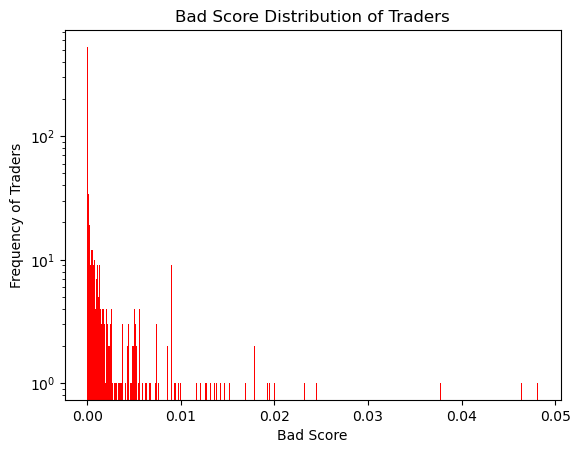

In [462]:
# plotting the output results
plt.hist(bad_scores , bins = 'auto' , color = 'r')
plt.yscale('log')
plt.title("Bad Score Distribution of Traders")
plt.xlabel("Bad Score")
plt.ylabel("Frequency of Traders")
plt.show()

In [463]:
print("The top 20 bad traders with their bad scores are: ")
print(final_df.sort_values(by=['Bad Score'] , ascending=False).head(20))

The top 20 bad traders with their bad scores are: 
     Trader ID  Bad Score
87        1088   0.048159
141       1144   0.046401
6         1007   0.037647
203       1210   0.024521
33        1034   0.023195
38        1039   0.020017
10        1011   0.019433
41        1042   0.019227
85        1086   0.017886
75        1076   0.017849
290       1309   0.016856
93        1094   0.015157
144       1147   0.014666
167       1173   0.014256
97        1099   0.013732
194       1201   0.013540
119       1122   0.013195
78        1079   0.012787
135       1138   0.012648
40        1041   0.012113
